In [1]:
%reset -f 
from LyapunovStableController import *
from Dynamics import *

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

2023-08-02 21:14:45.906509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os, datetime
datestring = datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S");
path = os.path.join(os.path.abspath(''),datestring)
os.makedirs(path)

## Initialise and Learn Lyapunov Stable Controller

[-3.141592653589793, -3.018392941684311, -2.8976572240169385, -2.7793855005876758, -2.6635777713965227, -2.550234036443479, -2.4393542957285455, -2.330938549251721, -2.2249867970130066, -2.1214990390124013, -2.020475275249906, -1.9219155057255206, -1.8258197304392445, -1.7321879493910781, -1.6410201625810212, -1.5523163700090743, -1.4660765716752369, -1.382300767579509, -1.3009889577218907, -1.2221411421023822, -1.1457573207209835, -1.0718374935776942, -1.0003816606725144, -0.9313898220054445, -0.8648619775764842, -0.8007981273856335, -0.7391982714328925, -0.680062409718261, -0.6233905422417393, -0.5691826690033273, -0.5174387900030247, -0.4681589052408319, -0.42134301471674873, -0.37699111843077515, -0.33510321638291124, -0.295679308573157, -0.25871939500151236, -0.22422347566797737, -0.19219155057255205, -0.16262361971523634, -0.1355196830960303, -0.11087974071493387, -0.0887037925719471, -0.06899183866706997, -0.05174387900030248, -0.036959913571644624, -0.024639942381096416, -0.014

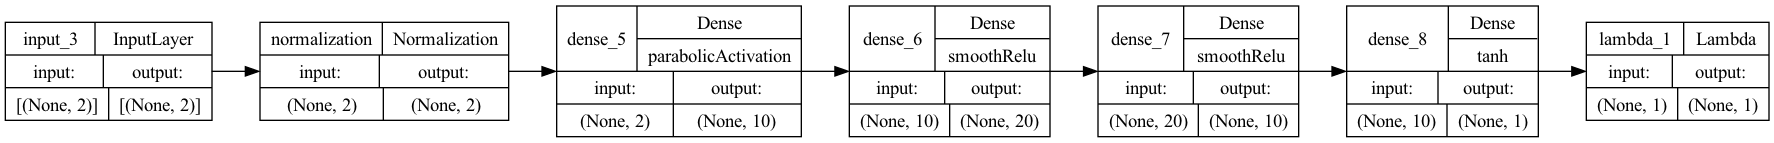

In [3]:
epochs = 60
batchsize = 10
batchsizeStep = epochs
batchsizeIncrement = 0
refinement = 50
gridtype = 'lin'
lam1 = 1       # Weighting factor lambda1 for actuator energy 
lam2 = 0       # Weighting factor lambda2 for wightin factor w 
alpha = .5     # Weighting factor for Lyapunov function norm term
lr = 1e-3
lrRampStep = 3
lrRampFactor = 0.75

LSC = LyapunovStableController(num_states=2,num_target=2,dynamics=TfDynamics,refinement=refinement,gridtype=gridtype)

tf.keras.utils.plot_model(LSC.model_c,to_file=path+'/model_c.png',show_shapes=True,show_layer_names=True,rankdir='LR',dpi=96,show_layer_activations=True)
tf.keras.utils.plot_model(LSC.model_l,to_file=path+'/model_l.png',show_shapes=True,show_layer_names=True,rankdir='LR',dpi=96,show_layer_activations=True)

In [4]:
LossHistory = LSC.trainNNs(epochs=epochs,batchsize=batchsize,batchsizeStep=batchsizeStep,batchsizeIncrement=batchsizeIncrement,lam1=lam1,lam2=lam2,alpha=alpha,lr=lr,lrRampStep=lrRampStep,lrRampFactor=lrRampFactor,HeunBool=True)

[-3.141592653589793, -3.018392941684311, -2.8976572240169385, -2.7793855005876758, -2.6635777713965227, -2.550234036443479, -2.4393542957285455, -2.330938549251721, -2.2249867970130066, -2.1214990390124013, -2.020475275249906, -1.9219155057255206, -1.8258197304392445, -1.7321879493910781, -1.6410201625810212, -1.5523163700090743, -1.4660765716752369, -1.382300767579509, -1.3009889577218907, -1.2221411421023822, -1.1457573207209835, -1.0718374935776942, -1.0003816606725144, -0.9313898220054445, -0.8648619775764842, -0.8007981273856335, -0.7391982714328925, -0.680062409718261, -0.6233905422417393, -0.5691826690033273, -0.5174387900030247, -0.4681589052408319, -0.42134301471674873, -0.37699111843077515, -0.33510321638291124, -0.295679308573157, -0.25871939500151236, -0.22422347566797737, -0.19219155057255205, -0.16262361971523634, -0.1355196830960303, -0.11087974071493387, -0.0887037925719471, -0.06899183866706997, -0.05174387900030248, -0.036959913571644624, -0.024639942381096416, -0.014

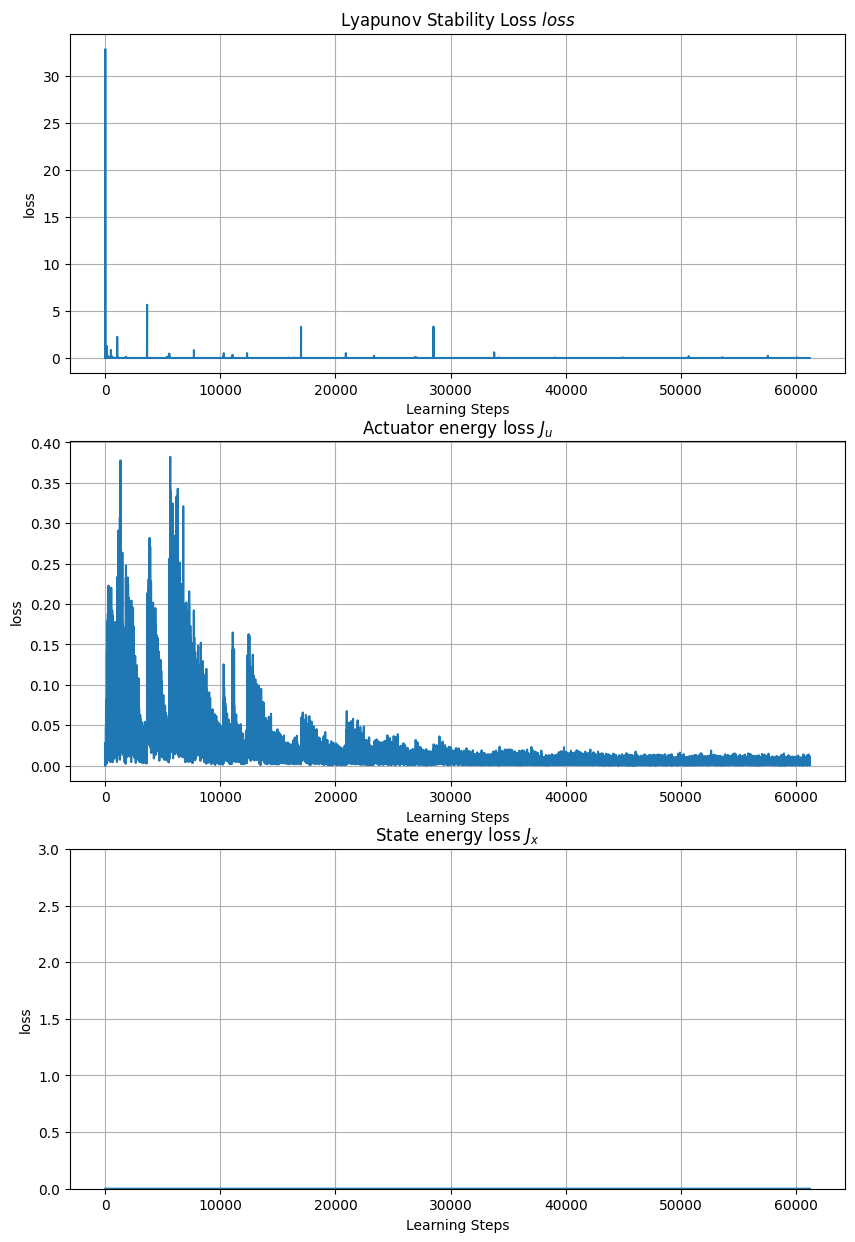

In [5]:
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(LossHistory[0,:]/batchsize)
plt.xlabel('Learning Steps')
plt.ylabel('loss')
plt.title('Lyapunov Stability Loss $loss$')
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(LossHistory[1,:]/batchsize)
plt.xlabel('Learning Steps')
plt.ylabel('loss')
plt.title('Actuator energy loss $J_u$')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(LossHistory[2,:]/batchsize)
plt.xlabel('Learning Steps')
plt.ylabel('loss')
plt.grid(True)
plt.ylim((0,3))
plt.title('State energy loss $J_x$')
plt.savefig(path+'/LearningHisory.png')
plt.show()

## Simulate controlled System 

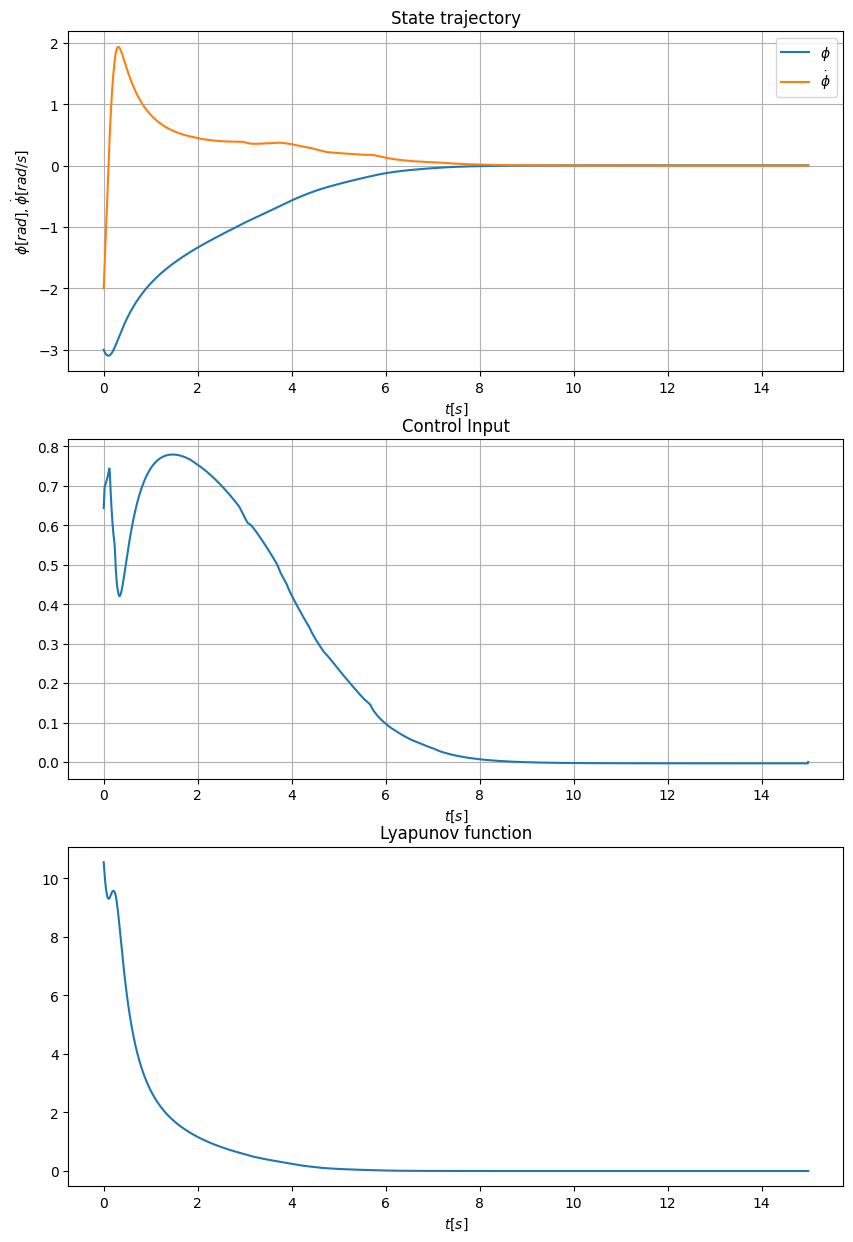

In [23]:
t = np.arange(0, 15, 0.01)
u = np.zeros((len(t),))
Ly = np.zeros((len(t),))
y = np.array([[-3,-2]])
time = np.array([0])

for i in range(len(t)-1):
    c = LSC.controlNN(y[-1,:])
    u[i] = c
    Ly[i] = max((LSC.lyapunovNN(y[-1,:])-LSC.lyapunovNN([[0],[0]])),0) + 0.5 * np.sum(np.power(y[-1,:],2))
    sol = solve_ivp(Dynamics, [t[i], t[i+1]], y[-1,:], t_eval=np.linspace(t[i],t[i+1], 100),args=(c,), method='BDF')
    yt = sol.y
    y = np.concatenate((y,sol.y.transpose()),axis = 0)
    time = np.concatenate((time,sol.t),axis = 0)

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(time,y[:,0])
plt.plot(time,y[:,1])
plt.title('State trajectory')
plt.legend(['$\phi$','$\dot \phi$'])
plt.xlabel('$t[s]$')
plt.ylabel('$\phi [rad], \dot \phi [rad/s]$')
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(t,u)
plt.title('Control Input')
plt.xlabel('$t[s]$')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(t,Ly)
plt.title('Lyapunov function')
plt.xlabel('$t[s]$')
#plt.savefig(path+'/Sim1.png')
plt.show()


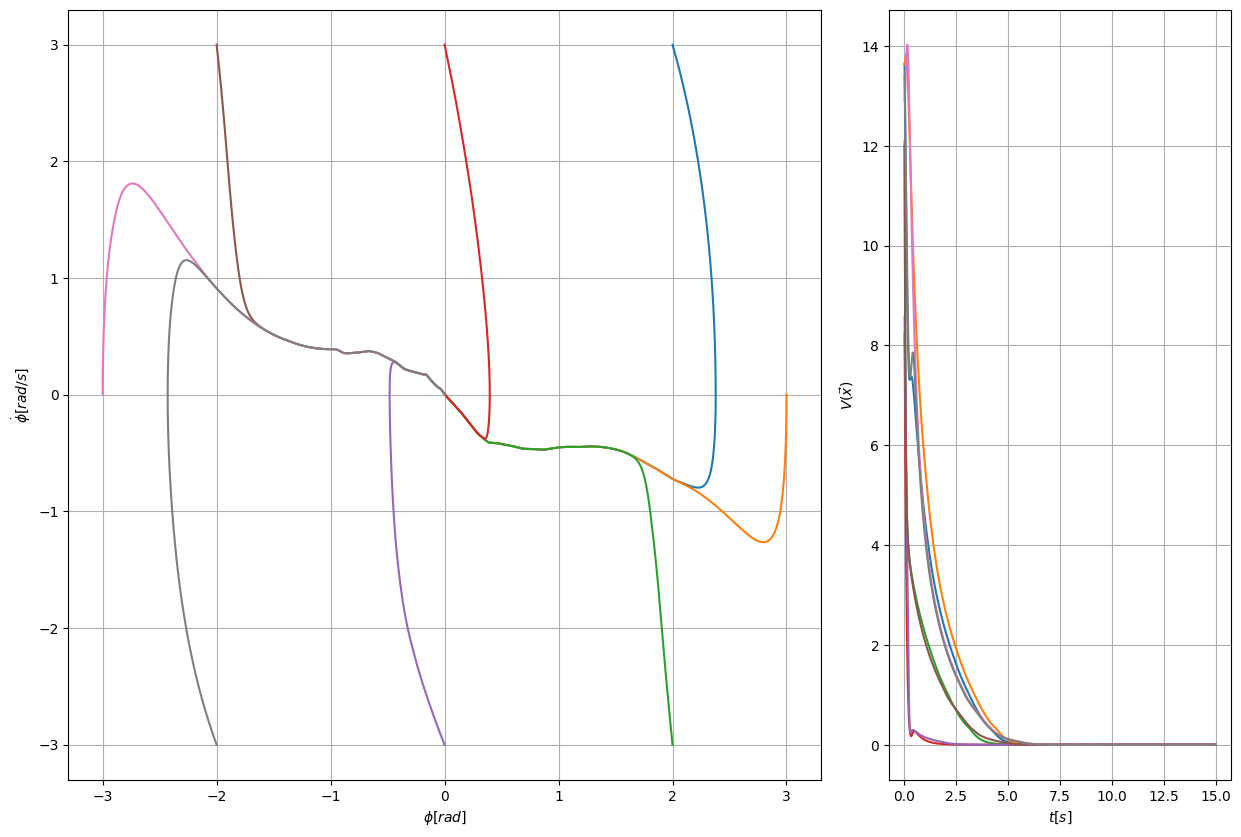

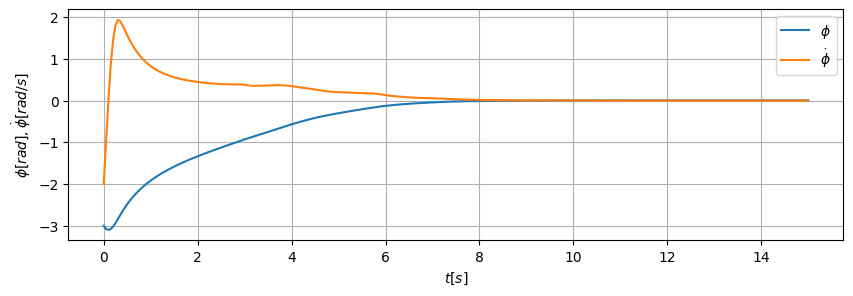

In [7]:

plt.figure(figsize=(15,10))
sp1 = plt.subplot(1,3,(1,2))
sp2 = plt.subplot(1,3,3)
y0 = np.array([[2,3,2,0,0,-2,-3,-2],[3,0,-3,3,-3,3,0,-3]])
for j in range(8):
    y = np.array([y0[:,j]])
    Ly = np.array([])
    for i in range(len(t)-1):
        c = LSC.controlNN(y[-1,:])
        sol = solve_ivp(Dynamics, [t[i], t[i+1]], y[-1,:], t_eval=np.linspace(t[i],t[i+1], 100),args=(c,), method='BDF')
        yt = sol.y
        y = np.concatenate((y,sol.y.transpose()),axis = 0)
        Ly = np.append(Ly,max((LSC.lyapunovNN(y[-1,:])-LSC.lyapunovNN([[0],[0]])),0) + 0.5 * np.sum(np.power(y[-1,:],2)))
    sp1.plot(y[:,0],y[:,1])
    sp1.set_xlabel('$\phi [rad]$')
    sp1.set_ylabel('$\dot \phi [rad/s]$')
    sp2.plot(t[1:],Ly)
sp2.set_ylabel(''r'$V(\vec x)$')
sp2.set_xlabel('$t [s]$')
sp1.grid(True)
sp2.grid(True)
plt.savefig(path+'/Sim2.png')
plt.show()

def ControlledDynamics(t,y):
    c = LSC.controlNN(y)
    return Dynamics(t,y,c)

sol = solve_ivp(ControlledDynamics, [0,15], [-3,-2], t_eval=np.linspace(0,15,300), method='BDF')

plt.figure(figsize=(10,3))
plt.plot(sol.t,sol.y[0,:])
plt.plot(sol.t,sol.y[1,:])
plt.legend(['$\phi$','$\dot \phi$'])
plt.xlabel('$t[s]$')
plt.ylabel('$\phi [rad], \dot \phi [rad/s]$')
plt.grid(True)
plt.savefig(path+'/Sim3.png')
plt.show()


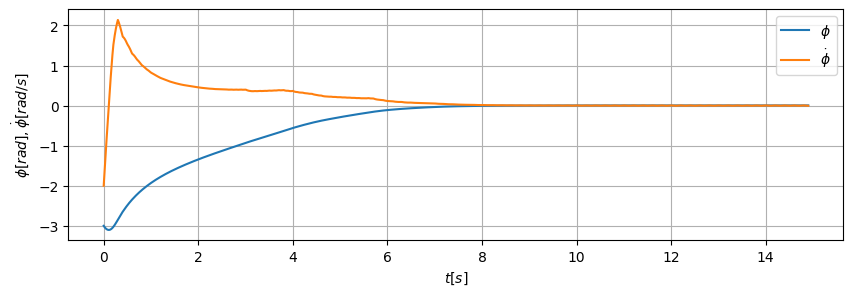

In [8]:

t = np.arange(0, 15, 0.1)
y = np.array([[-3,-2]])
time = np.array([0])

for i in range(len(t)-1):
    c = LSC.controlNN(y[-1,:])
    sol = solve_ivp(Dynamics, [t[i], t[i+1]], y[-1,:], t_eval=np.linspace(t[i],t[i+1], 100),args=(c,), method='BDF')
    yt = sol.y
    y = np.concatenate((y,sol.y.transpose()),axis = 0)
    time = np.concatenate((time,sol.t),axis = 0)

plt.figure(figsize=(10,3))
plt.plot(time,y[:,0])
plt.plot(time,y[:,1])
plt.legend(['$\phi$','$\dot \phi$'])
plt.xlabel('$t[s]$')
plt.ylabel('$\phi [rad], \dot \phi [rad/s]$')
plt.grid(True)
plt.savefig(path+'/Sim4.png')
plt.show()

## Visulaise Controller Specific Data

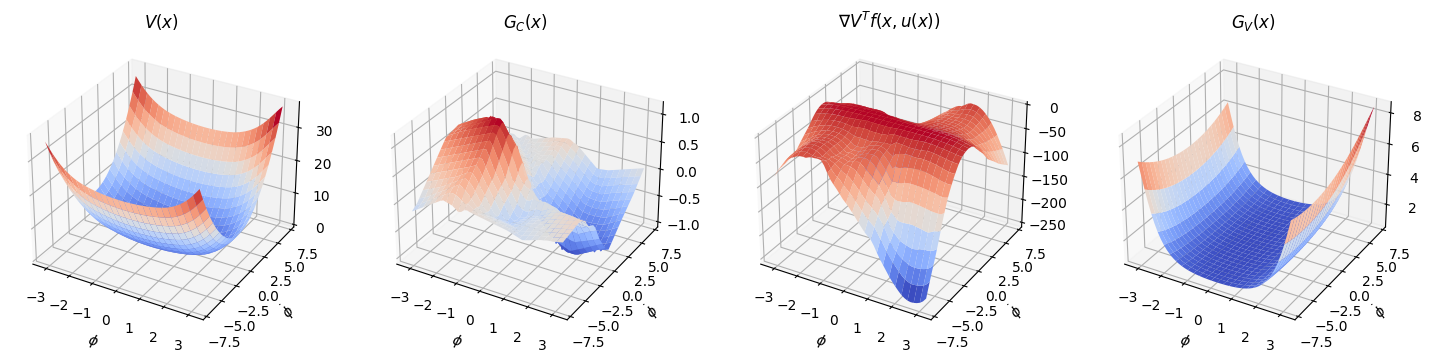

/Users/manuelwendl/Dokumente/Projects/Programming Projects/Data Science Introduction in Science/Code Python/NonlinearControl/LyapunovStableController.py:394: UserWarning: No contour levels were found within the data range.
  plt.contour(phi,dphi,dLyapunov,levels=[0])


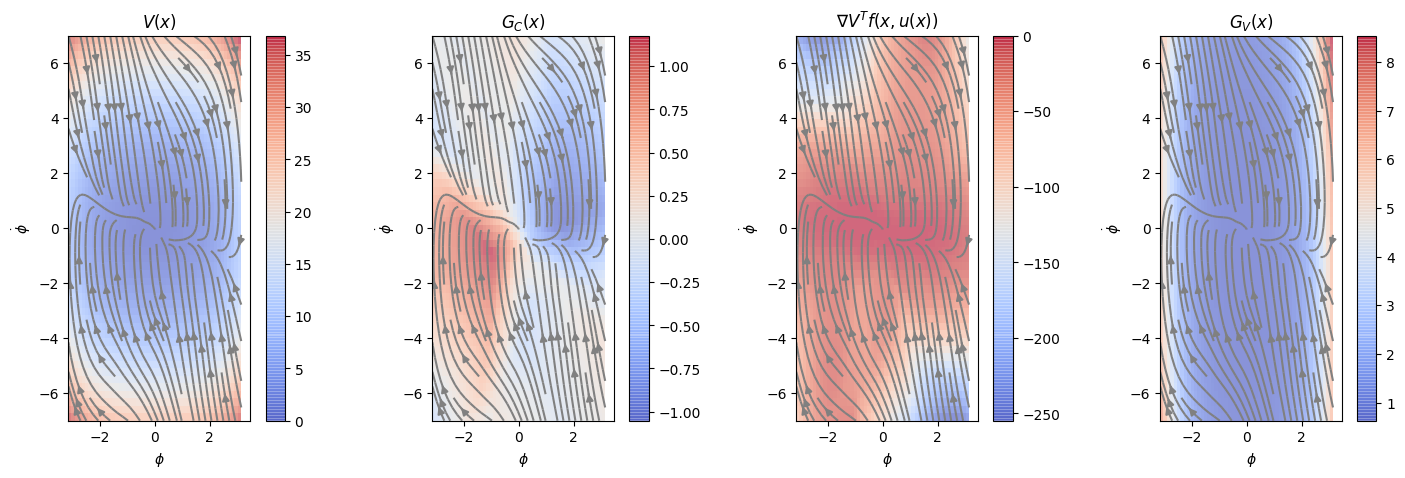

In [9]:
LSC.VisualiseController()

In [10]:
LSC.model_c.save(os.path.join(path,'Model_C_'+datestring+'.h5'))
LSC.model_l.save(os.path.join(path,'Model_L_'+datestring+'.h5'))

Uncontrolled Dynmaics

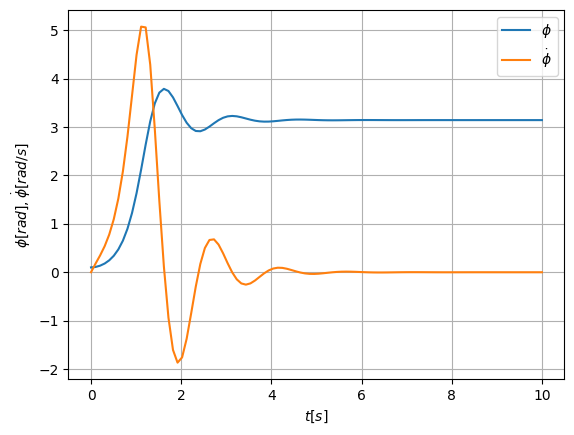

In [11]:
sol = solve_ivp(Dynamics, [0,10], [0.1,0], t_eval=np.linspace(0,10,100),args=(0,),method='BDF')

plt.figure()
plt.plot(sol.t,sol.y[0,:])
plt.plot(sol.t,sol.y[1,:])
plt.legend(['$\phi$','$\dot \phi$'])
plt.xlabel('$t[s]$')
plt.ylabel('$\phi [rad], \dot \phi [rad/s]$')
plt.grid(True)
plt.show()

## LQR Comparison

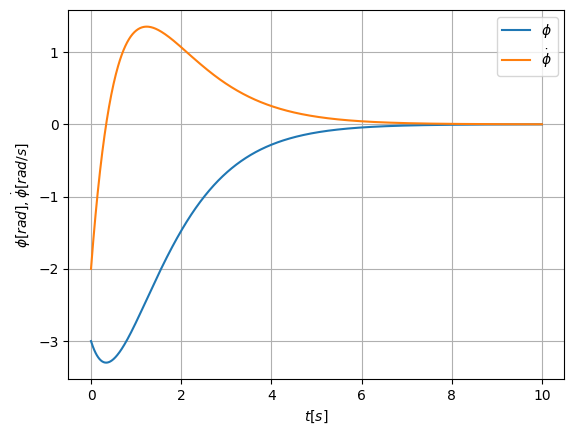

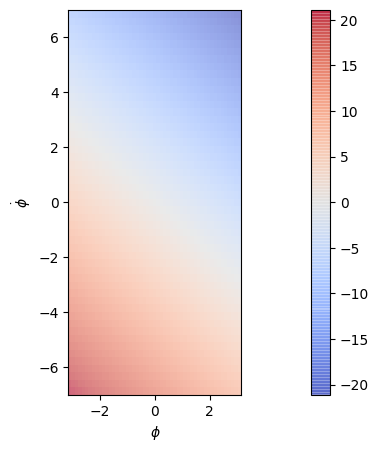

In [21]:
import control

# Linearised System
m = 0.15; g = 9.81; L = 0.5; b = 0.1
A = np.array([[0,1],[m*g*L,-b]])
B = np.array([[0],[1]])

Q = np.array([[1,0],[0,1]])
R = 1

K, S, E = control.lqr(A, B, Q, R)

def linearPendulum(t,y):
    y = np.array(y)
    return A@y.transpose()- B@K@y.transpose()

sol = solve_ivp(linearPendulum, [0, 20], [-3,-2], t_eval=np.linspace( 0, 10, 1000))

plt.figure()
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])
plt.legend(['$\phi$','$\dot \phi$'])
plt.xlabel('$t[s]$')
plt.ylabel('$\phi [rad], \dot \phi [rad/s]$')
plt.grid(True)
plt.show()


[phi,dphi] = np.meshgrid(np.linspace(-np.pi,np.pi,51),np.linspace(-7,7,51))
u = np.zeros(phi.shape)

for i in range(51):
    for j in range(51):
        state = [[phi[i,j]],[dphi[i,j]]] 
        u[i,j] = -K@state


plt.figure(figsize=(18,5))
plt.imshow(u,cmap='coolwarm',extent=[phi[0,0],phi[0,-1],dphi[0,0],dphi[-1,0]],origin='lower',alpha=0.6)
plt.colorbar()
plt.xlabel('$\phi$')
plt.ylabel('$\dot \phi$')
plt.show()
